# Computational Structural Design II - Geometry, Data and Visualization

### Learning Goal: 
- Mesh Datastructure

### Content:
- [A. Mesh Introduction](#MeshIntro)
- 
---


<a id='MeshIntro'></a>
# A. Mesh Introduction

Form finding a cable-net or generating a compression-only vault usually starts with a **2D mesh**, which represents the horizontal projection of the eventual structure. The line segments of this mesh is called **Pattern**. The following picture shows you an existing structure and its corresponding pattern. The form-found **Thrust** is also a mesh, but in 3D space. 

![img](https://files.gitbook.com/v0/b/gitbook-legacy-files/o/assets%2F-M730QpQnbAMvz44bqhc%2F-MOff3g181Ib3KNlmKgc%2F-MOfhAWYJRaSfNZucLzL%2Fimage.png?alt=media&token=839252d4-a77e-42cb-81cf-4b6071a5c598)
<center>Nave Vault of the Sherborne Abbey, Dorset, UK (photo by Lawrence Lew)</center>
</br>



# B. From Polygon to Polygon Mesh

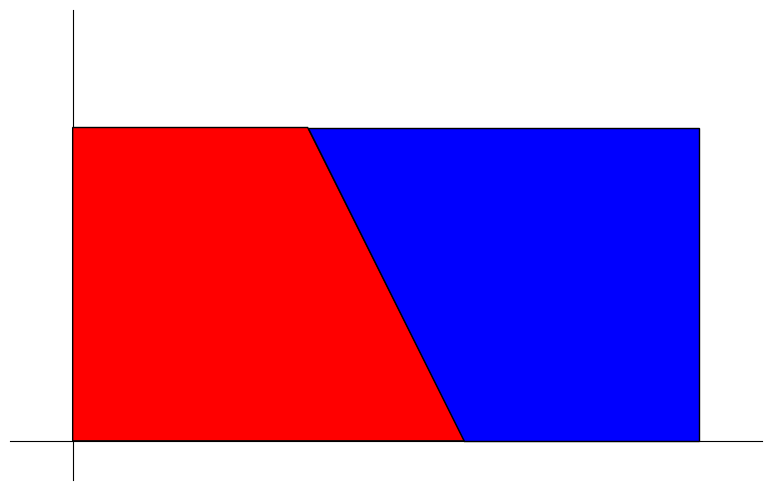

In [102]:
from compas.geometry import Polygon
from compas_plotters import Plotter

polygon_1 = Polygon([[0, 0], [2.5, 0], [1.5, 2], [0, 2]])
polygon_2 = Polygon([[2.5, 0], [4, 0], [4, 2], [1.5, 2]])
polygon_3 = Polygon([[0, 2], [1.5, 2], [2.5, 4], [0, 4]])

# visualize the Point
plotter = Plotter(show_axes=True)
plotter.add(polygon_1, facecolor=(1, 0, 0))
plotter.add(polygon_2, facecolor=(0, 0, 1))
plotter.zoom_extents()
plotter.show()




## B. Mesh Vertex, Edge, Face

Mesh has three main components: vertex, edge, face. 

A vertex is a point in 3D space, represented by the [x, y, z] coordinate. 

PICTURE TO BE INSERTED

An edge connects two vertices together. 

PICTURE TO BE INSERTED

A face is constructed by connecting the edges together. A 3D geometry can be constructed by connecting faces together. 

PICTURE TO BE INSERTED

Mesh talks how the points are connected. It's about connectivity instead of the geometry. 

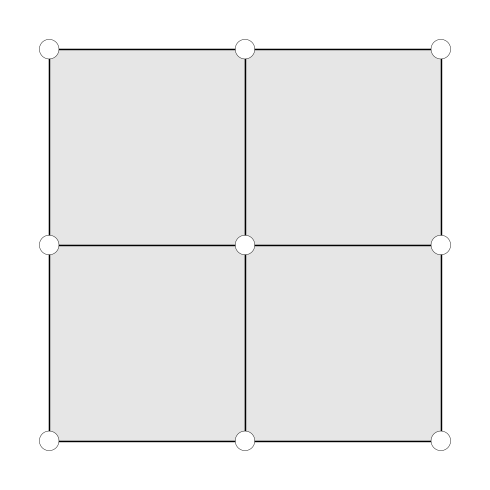

In [93]:
from compas.datastructures import Mesh
from compas_plotters import Plotter

plotter = Plotter(figsize=(5, 5))

mesh = Mesh.from_meshgrid(dx=2, nx=2)
plotter.add(mesh, sizepolicy='absolute')
plotter.zoom_extents()
plotter.show()

## A2. COMPAS Mesh
A thrust object we created in RV2 is also a mesh. Let's try to find the vertices, edges, faces on a mesh. 

In [3]:
import os
from compas.datastructures import Mesh

HERE = os.getcwd()
DATA = os.path.abspath(os.path.join(HERE, 'data'))
FILE_I = os.path.join(DATA, 'simple_dome.json')

thrust = Mesh.from_json(FILE_I)


In [5]:
from compas_view2.app import App
viewer = App()
viewer.add(thrust)
viewer.run()


In [6]:
mesh = Mesh.from_json(FILE_I)
vertices = list(mesh.vertices())
edges = list(mesh.edges())
faces = list(mesh.faces())
# print(vertices, edges, faces)

## Add Vertices

In [14]:
from compas.geometry import Sphere
viewer = App()
viewer.add(mesh)
for vkey in mesh.vertices():
    viewer.add(Sphere(mesh.vertex_coordinates(vkey), 0.05), color=(1, 0, 0))

viewer.run()

## Add Edges

In [13]:
from compas.geometry import Plane, Vector, Circle, Cylinder
from compas_view2.app import App

viewer = App()
# viewer.add(mesh)
for (u, v) in mesh.edges():
    u_xyz = mesh.vertex_coordinates(u)
    v_xyz = mesh.vertex_coordinates(v)

# pipe:   circle ([plane, radius] | Circle) – The circle of the cylinder.
#         height (float) – The height of the cylinder.
    center = [0.5 * (a + b) for a, b in zip(u_xyz, v_xyz)]
    normal = Vector.from_start_end(v_xyz, u_xyz)
    plane = Plane(center, normal) # center, normal
    circle = Circle(plane, 0.05)
    
    cylinder = Cylinder(circle, normal.length - 0.1)
    viewer.add(cylinder)
    


viewer.run()

## Add Faces

In [85]:
from compas.geometry import Polygon, offset_polygon, normal_polygon, offset_line, intersection_line_line, centroid_points
from compas_view2.app import App
from compas.utilities import is_item_iterable, iterable_like, pairwise

viewer = App()

distance = 0.1 
tol = 1e-3

def intersect_lines(l1, l2, tol):
    x1, x2 = intersection_line_line(l1, l2, tol)
    if x1 and x2:
        return centroid_points([x1, x2])
    
def offset_segments(point_list, distances, normal):
    segments = []
    for line, distance in zip(pairwise(point_list), distances):
        segments.append(offset_line(line, distance, normal))
    return segments

def intersect(l1, l2, tol):
    supported_funcs = [intersect_lines, intersect_lines_colinear]
    for func in supported_funcs:
        point = func(l1, l2, tol)
        if point:
            return point
    msg = "Intersection not found for line: {}, and line: {}".format(l1, l2)
    raise ValueError(msg)

def intersect_lines_colinear(l1, l2, tol):
    def are_segments_colinear(l1, l2, tol):
        a, b = l1
        d, c = l2
        return is_colinear(a, b, c, tol)
    if are_segments_colinear(l1, l2, tol):
        return centroid_points([l1[1], l2[0]])
    
for fkey in mesh.faces():
    vkeys = mesh.face_vertices(fkey)
    v_xyzs = [mesh.vertex_coordinates(vkey) for vkey in vkeys]
    polygon = Polygon(v_xyzs)
    
    normal = normal_polygon(polygon)

    if not is_item_iterable(distance):
        distance = [distance]
    distances = iterable_like(polygon, distance, distance[-1])

    polygon = polygon.points + polygon[:1]
    segments = offset_segments(polygon, distances, normal)

    offset = []
    for s1, s2 in pairwise(segments[-1:] + segments):
        point = intersect(s1, s2, tol)
        offset.append(point)
    
#     offset_polygon = offset_polygon(v_xyzs, -0.1, 0.5)
#     print(offset_polygon)
    viewer.add(Polygon(offset))
        
viewer.run()

In [88]:
from compas.geometry import Polygon, offset_polygon, normal_polygon, offset_line, intersection_line_line, centroid_points
from compas_view2.app import App
from compas.utilities import is_item_iterable, iterable_like, pairwise

viewer = App()

distance = 0.1 
tol = 1e-3

def intersect_lines(l1, l2, tol):
    x1, x2 = intersection_line_line(l1, l2, tol)
    if x1 and x2:
        return centroid_points([x1, x2])
    
def offset_segments(point_list, distances, normal):
    segments = []
    for line, distance in zip(pairwise(point_list), distances):
        segments.append(offset_line(line, distance, normal))
    return segments

def intersect(l1, l2, tol):
    supported_funcs = [intersect_lines, intersect_lines_colinear]
    for func in supported_funcs:
        point = func(l1, l2, tol)
        if point:
            return point
    msg = "Intersection not found for line: {}, and line: {}".format(l1, l2)
    raise ValueError(msg)

def intersect_lines_colinear(l1, l2, tol):
    def are_segments_colinear(l1, l2, tol):
        a, b = l1
        d, c = l2
        return is_colinear(a, b, c, tol)
    if are_segments_colinear(l1, l2, tol):
        return centroid_points([l1[1], l2[0]])
    
for fkey in mesh.faces():
    vkeys = mesh.face_vertices(fkey)
    v_xyzs = [mesh.vertex_coordinates(vkey) for vkey in vkeys]
    polygon = Polygon(v_xyzs)
    
#     normal = normal_polygon(polygon)

#     if not is_item_iterable(distance):
#         distance = [distance]
#     distances = iterable_like(polygon, distance, distance[-1])

#     polygon = polygon.points + polygon[:1]
#     segments = offset_segments(polygon, distances, normal)

#     offset = []
#     for s1, s2 in pairwise(segments[-1:] + segments):
#         point = intersect(s1, s2, tol)
#         offset.append(point)
    
    offset_polygon = offset_polygon(v_xyzs, -0.1, tol)
    print(offset_polygon)
    viewer.add(Polygon(offset))
        
viewer.run()

[[-0.45773186718607506, 10.157731867186074, -0.06245222870480714], [-0.25376065592553043, 8.94893620131229, 0.23361034012814977], [0.883250474867052, 8.816749525132948, 1.0179290079921222], [0.7510637986877111, 9.95376065592553, 0.23361034012814996]]


TypeError: 'list' object is not callable